In [8]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


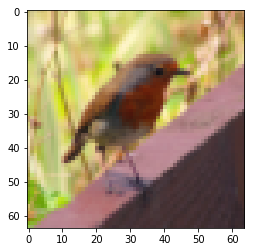

In [13]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [14]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)



<img src="https://zedwnutwhnkzdykkpsnyql.coursera-apps.org/notebooks/Week%204/Deep%20Neural%20Network%20Application:%20Image%20Classification/images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>


In [15]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## 搭建两层神经网络
一个两层的神经网络模型图如下：

<img src="https://zedwnutwhnkzdykkpsnyql.coursera-apps.org/notebooks/Week%204/Deep%20Neural%20Network%20Application:%20Image%20Classification/images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> 该模型可以概括为: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

我们正式开始构建两层的神经网络:


In [16]:
def two_layer_model(X,Y,layers_dims,learning_rate=0.0075,num_iterations=3000,print_cost=False,isPlot=True):
    """
    实现一个两层的神经网络，【LINEAR->RELU】 -> 【LINEAR->SIGMOID】
    参数：
        X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    返回:
        parameters - 一个包含W1，b1，W2，b2的字典变量
    """
    np.random.seed(1)
    grads = {}
    costs = []
    (n_x,n_h,n_y) = layers_dims
    
    """
    初始化参数
    """
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    """
    开始进行迭代
    """
    for i in range(0,num_iterations):
        #前向传播
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        #计算成本
        cost = compute_cost(A2,Y)
        
        #后向传播
        ##初始化后向传播
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        ##向后传播，输入：“dA2，cache2，cache1”。 输出：“dA1，dW2，db2;还有dA0（未使用），dW1，db1”。
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        ##向后传播完成后的数据保存到grads
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2
        
        #更新参数
        parameters = update_parameters(parameters,grads,learning_rate)
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        #打印成本值，如果print_cost=False则忽略
        if i % 100 == 0:
            #记录成本
            costs.append(cost)
            #是否打印成本值
            if print_cost:
                print("第", i ,"次迭代，成本值为：" ,np.squeeze(cost))
    #迭代完成，根据条件绘制图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    #返回parameters
    return parameters


我们现在开始加载数据集

In [19]:
import lr_utils

train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y



数据集加载完成，开始正式训练：

In [ ]:
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x,n_h,n_y)

parameters = two_layer_model(train_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True,isPlot=True)


第 0 次迭代，成本值为： 0.693049735659989
第 100 次迭代，成本值为： 0.6464320953428849
第 200 次迭代，成本值为： 0.6325140647912678
第 300 次迭代，成本值为： 0.6015024920354665
第 400 次迭代，成本值为： 0.5601966311605747
第 500 次迭代，成本值为： 0.5158304772764729
第 600 次迭代，成本值为： 0.4754901313943325
第 700 次迭代，成本值为： 0.43391631512257495
第 800 次迭代，成本值为： 0.4007977536203887
第 900 次迭代，成本值为： 0.35807050113237976
第 1000 次迭代，成本值为： 0.33942815383664127
第 1100 次迭代，成本值为： 0.30527536361962654
第 1200 次迭代，成本值为： 0.2749137728213016
第 1300 次迭代，成本值为： 0.24681768210614846


迭代完成之后我们就可以进行预测了，预测函数如下：

In [ ]:
def predict(X, y, parameters):
    """
    该函数用于预测L层神经网络的结果，当然也包含两层
    
    参数：
     X - 测试集
     y - 标签
     parameters - 训练模型的参数
    
    返回：
     p - 给定数据集X的预测
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # 神经网络的层数
    p = np.zeros((1,m))
    
    #根据参数前向传播
    probas, caches = L_model_forward(X, parameters)
    
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("准确度为: "  + str(float(np.sum((p == y))/m)))
        
    return p


预测函数构建好了我们就开始预测，查看训练集和测试集的准确性：

In [ ]:
predictions_train = predict(train_x, train_y, parameters) #训练集
predictions_test = predict(test_x, test_y, parameters) #测试集


## 搭建多层神经网络
我们首先来看看多层的网络的结构吧~
<img src="https://zedwnutwhnkzdykkpsnyql.coursera-apps.org/notebooks/Week%204/Deep%20Neural%20Network%20Application:%20Image%20Classification/images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> 该模型可以概括为: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False,isPlot=True):
    """
    实现一个L层神经网络：[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID。
    
    参数：
	    X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,···,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    
    返回：
     parameters - 模型学习的参数。 然后他们可以用来预测。
    """
    np.random.seed(1)
    costs = []
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0,num_iterations):
        AL , caches = L_model_forward(X,parameters)
        
        cost = compute_cost(AL,Y)
        
        grads = L_model_backward(AL,Y,caches)
        
        parameters = update_parameters(parameters,grads,learning_rate)
        
        #打印成本值，如果print_cost=False则忽略
        if i % 100 == 0:
            #记录成本
            costs.append(cost)
            #是否打印成本值
            if print_cost:
                print("第", i ,"次迭代，成本值为：" ,np.squeeze(cost))
    #迭代完成，根据条件绘制图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    return parameters


In [ ]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y



In [ ]:
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True,isPlot=True)



In [ ]:
# 训练完成，我们看一下预测：

pred_train = predict(train_x, train_y, parameters) #训练集
pred_test = predict(test_x, test_y, parameters) #测试集


## 分析
我们可以看一看有哪些东西在L层模型中被错误地标记了，导致准确率没有提高。

In [ ]:
def print_mislabeled_images(classes, X, y, p):
    """
	绘制预测和实际不同的图像。
	    X - 数据集
	    y - 实际的标签
	    p - 预测
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


print_mislabeled_images(classes, test_x, test_y, pred_test)

分析一下我们就可以得知原因了：
模型往往表现欠佳的几种类型的图像包括：

* 猫身体在一个不同的位置
* 猫出现在相似颜色的背景下
* 不同的猫的颜色和品种
* 相机角度
* 图片的亮度
* 比例变化（猫的图像非常大或很小）

## 【选做】
我们使用自己图片试试？
我们把一张图片放在一个特定位置，然后识别它。

In [ ]:

## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

